In [59]:
import os, glob
import numpy as np
import xarray as xr
from enum import Enum
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import sys
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
sys.path.append('modules')
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import constants
sys.path.append(constants.MODULE_DIR)
import open_ds
import xarray_class_accessors as xca
from importlib import reload
import sn_plotting
import utils
from warnings import filterwarnings
filterwarnings('ignore')
import open_ds
import classes
import signal_to_noise
from pprint import pprint
from classes import LocationsLatLon, ExperimentTypes

In [60]:
VARIABLE_INFO = constants.VARIABLE_INFO
pprint(VARIABLE_INFO)

{'netTOA': {'longname': 'Net TOA flux'},
 'pr': {'longname': 'Precipitation', 'units': 'mm\\year'},
 'psl': {'longname': 'Sea level pressure'},
 'sic': {'longname': 'Sea ice are fraction'},
 'surf': {'longname': 'Neat Ocean Heat Uptake'},
 'tas': {'longname': 'Near-surface air temperature', 'units': '$^{\\circ}C$'},
 'tos': {'longname': 'Sea surface temperature'}}


In [2]:
notebook_number = '05'

In [79]:
variable = 'pr' # pr
# pr: 'window_101_length_1000' tas: window_51_length_1000
window = 'window_101_length_1000'
ROOT_DIR = os.path.join(constants.LONGRUNMIP_DIR, variable)
ROOT_DIR_REGRID = os.path.join(ROOT_DIR, 'regrid_retimestamped')
ROOT_DIR_SN = os.path.join(ROOT_DIR, 'signal_to_noise',window)

In [80]:
longname = VARIABLE_INFO[variable]['longname']
longname

'Precipitation'

In [81]:
models_to_get = open_ds.get_models_longer_than_length()
utils.pprint_list(models_to_get, num_start_items=7)

lenght = 7
 0. ccsm3
 1. cesm104
 2. cnrmcm61
 3. hadcm3l
 4. ipslcm5a
 5. mpiesm11
 6. mpiesm12


In [82]:
os.listdir('/g/data/w40/ab2313/PhD/longrunmip/tas/signal_to_noise/')

['window_51_length_1000']

In [83]:
files_to_open_signal_to_noise = open_ds.get_file_names_from_from_directory(ROOT_DIR_SN,
                                                           classes.ExperimentTypes.SIGNAL_TO_NOISE,
                                                          models_to_get)

files_to_open_signal_to_noise_stable =\
                        open_ds.get_file_names_from_from_directory(ROOT_DIR_SN,
                                               classes.ExperimentTypes.SIGNAL_TO_NOISE_STABLE,
                                              models_to_get)

files_to_open_experiment = open_ds.get_file_names_from_from_directory(ROOT_DIR_REGRID,
                                                           ExperimentTypes.ABRUPT4X,
                                                           models_to_get)

files_to_open_control = open_ds.get_file_names_from_from_directory(ROOT_DIR_REGRID,
                                                           ExperimentTypes.CONTROL,
                                                           models_to_get)
utils.pprint_list(files_to_open_signal_to_noise)

- model='cesm104' - found_fname=None - No file found
- model='cesm104' - found_fname=None - No file found
lenght = 6
 0. signal_to_noise/ccsm3_signal_to_noise.nc
 1. signal_to_noise/cnrmcm61_signal_to_noise.nc


In [84]:
stable_ds = open_ds.open_and_concat_nc_files(files_to_open_signal_to_noise_stable, ROOT_DIR_SN, model_index=0)

sn_ds = open_ds.open_and_concat_nc_files(files_to_open_signal_to_noise, ROOT_DIR_SN, model_index=0)
sn_ds

Removing coords - ['variable']
Removing coords - ['variable']


<xarray.Dataset>
Dimensions:          (time: 1100, lon: 144, lat: 72, model: 6, variable: 1)
Coordinates:
  * time             (time) object 0001-12-31 00:00:00 ... 1100-12-31 00:00:00
  * lon              (lon) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * lat              (lat) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * model            (model) object 'ccsm3' 'cnrmcm61' ... 'mpiesm11' 'mpiesm12'
Dimensions without coordinates: variable
Data variables:
    signal_to_noise  (model, variable, time, lat, lon) float64 1.559 ... nan
    lower_bound      (model, variable, lat, lon) float64 -0.7634 ... -0.802
    upper_bound      (model, variable, lat, lon) float64 1.035 1.048 ... 0.9053

In [85]:
abrupt4x_ds = open_ds.read_and_merge_netcdfs(files_to_open_experiment, ROOT_DIR_REGRID)
control_ds = open_ds.read_and_merge_netcdfs(files_to_open_control, ROOT_DIR_REGRID)

- model='cesm104' is too short has time_length=112 < requested_length=800
(fname='pr_mon_CESM104_abrupt4x_5900_g025.nc')


In [86]:
# Anomalies
abrupt4x_anom_ds = abrupt4x_ds.clima_ds.anomalies(control_ds)

ccsm3, cnrmcm61, hadcm3l, ipslcm5a, mpiesm11, mpiesm12, 

In [87]:
period_list = (utils.create_period_list(step = 25, end = 2, start = 0) +
               utils.create_period_list(step = 50, end = 9, start = 1)) 
utils.pprint_list(period_list)

lenght = 10
 0. (0, 24)
 1. (25, 49)


In [88]:
percent_stable_ds = signal_to_noise.percent_of_non_nan_points_in_period(stable_ds, period_list)

In [89]:
pattern_corr_df = signal_to_noise.pattern_correlation_of_models(percent_stable_ds['percent'])
pattern_corr_df.head()

0_24     25_49     50_99   100_149   150_199   200_249  \
ccsm3     0.268535  0.140730  0.043060  0.036354  0.064074  0.019523   
cnrmcm61  0.465207  0.276681  0.196164  0.160179  0.092351 -0.006852   
hadcm3l   0.144892 -0.068442  0.035200  0.012214  0.046276  0.031058   
ipslcm5a  0.466029  0.354110  0.217453  0.051819  0.110820  0.056412   
mpiesm11  0.373954  0.274589  0.324383  0.117783  0.057104  0.046568   

           250_299   300_349   350_399   400_449  
ccsm3    -0.034983  0.013942 -0.002034  0.036658  
cnrmcm61  0.053294  0.067940  0.086471 -0.004300  
hadcm3l   0.007043  0.066361  0.061780  0.034308  
ipslcm5a -0.043797  0.126149  0.100748 -0.004659  
mpiesm11  0.025760  0.090942  0.014566  0.023567

## Plotting

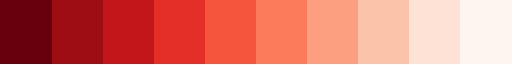

In [90]:
cmap = plt.cm.get_cmap('Reds_r', 10)
cmap

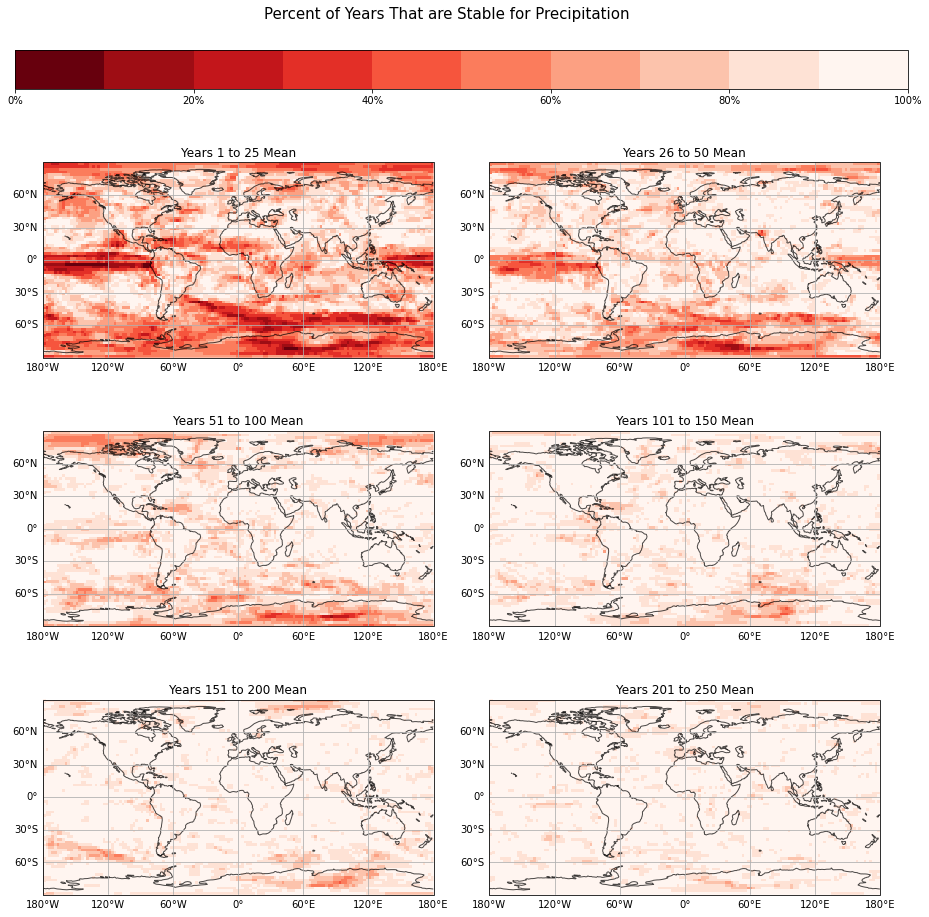

In [91]:
#### This will errror. See above for reeasons why

periods = percent_stable_ds.period.values[:6]

fig, gs, cbar = sn_plotting.plot_all_period_maps(
    percent_stable_ds['mean'].to_dataset(), periods,
    suptitle = f'Percent of Years That are Stable for {longname}', 
    cmap=cmap, 
    col_increase = 2)

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, 
                         f'{notebook_number}_{variable}_percent_years_stable_{window}.png'),
           bbox_inches='tight', dpi=250)

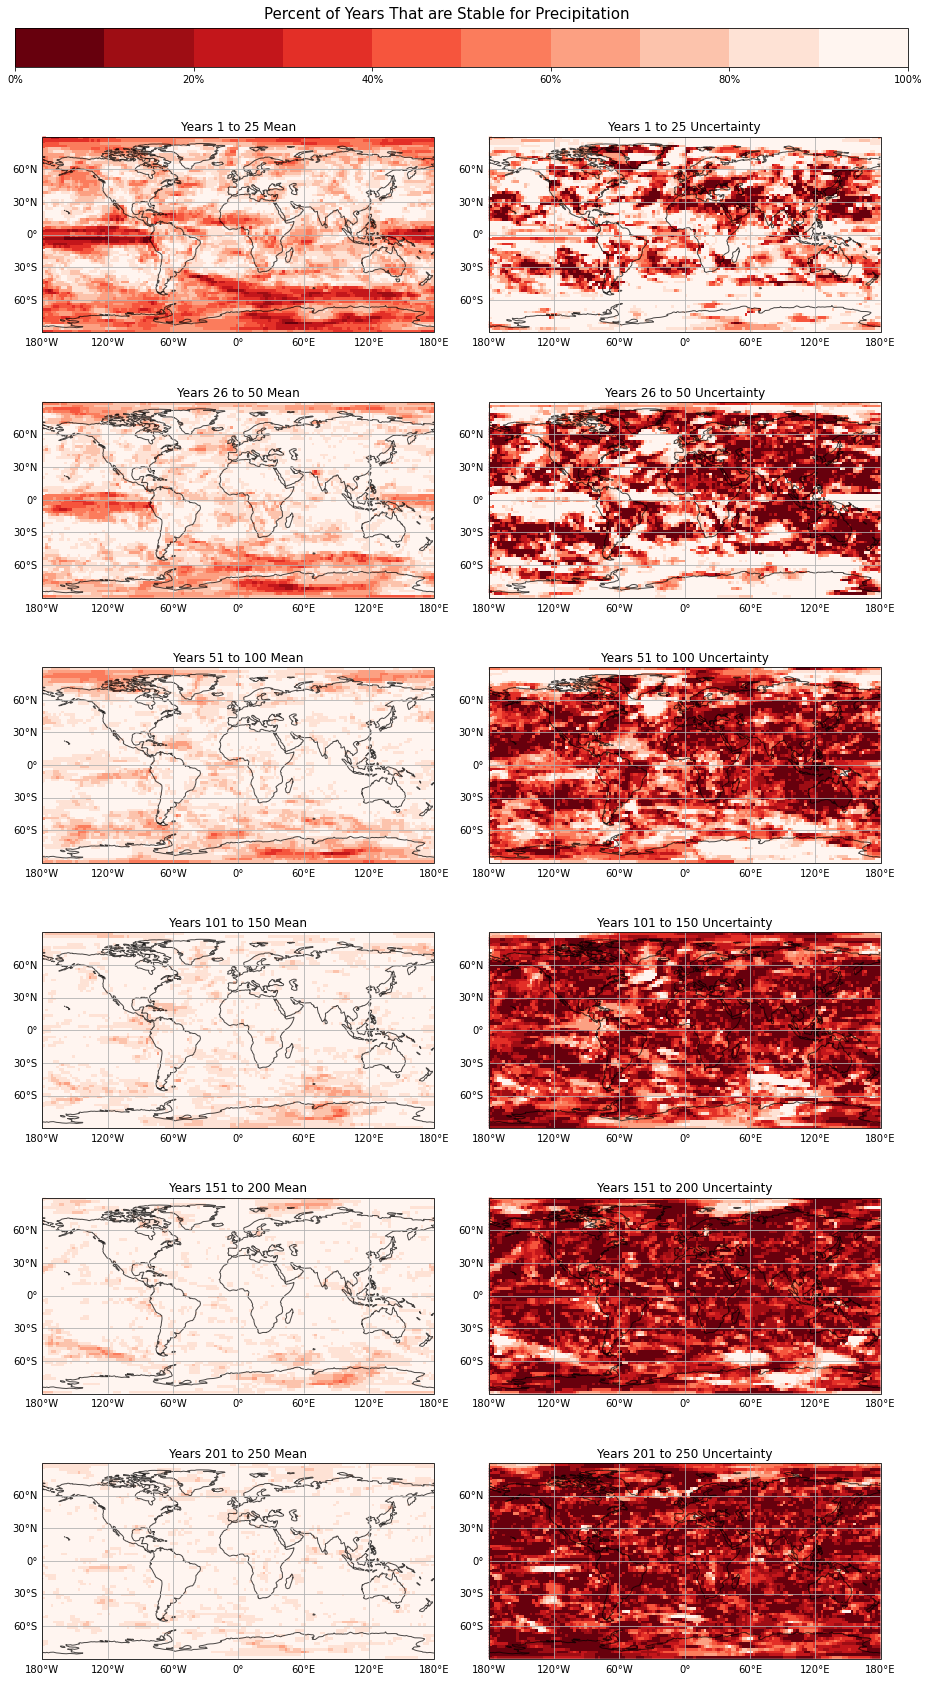

In [92]:
periods = percent_stable_ds.period.values[:6]

fig, gs, cbar =  sn_plotting.plot_all_period_maps(percent_stable_ds[['mean', 'uncertainty']], periods,
                                       suptitle = f'Percent of Years That are Stable for {longname}', 
                                                  cmap=cmap,
                                                 row_increase=1)

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, 
                         f'{notebook_number}_{variable}_percent_years_stable_and_uncertainty_{window}.png'),
           bbox_inches='tight', dpi=250)

In [93]:
percent_stable_ds

<xarray.Dataset>
Dimensions:      (lon: 144, lat: 72, period: 10, variable: 1, model: 6)
Coordinates:
  * lon          (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat          (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * period       (period) object '0_24' '25_49' '50_99' ... '350_399' '400_449'
  * model        (model) object 'ccsm3' 'cnrmcm61' ... 'mpiesm11' 'mpiesm12'
Dimensions without coordinates: variable
Data variables:
    mean         (period, variable, lat, lon) float64 59.33 59.33 ... 94.67
    uncertainty  (period, variable, lat, lon) float64 96.0 96.0 ... 20.0 20.0
    percent      (period, model, variable, lat, lon) float64 64.0 64.0 ... 98.0

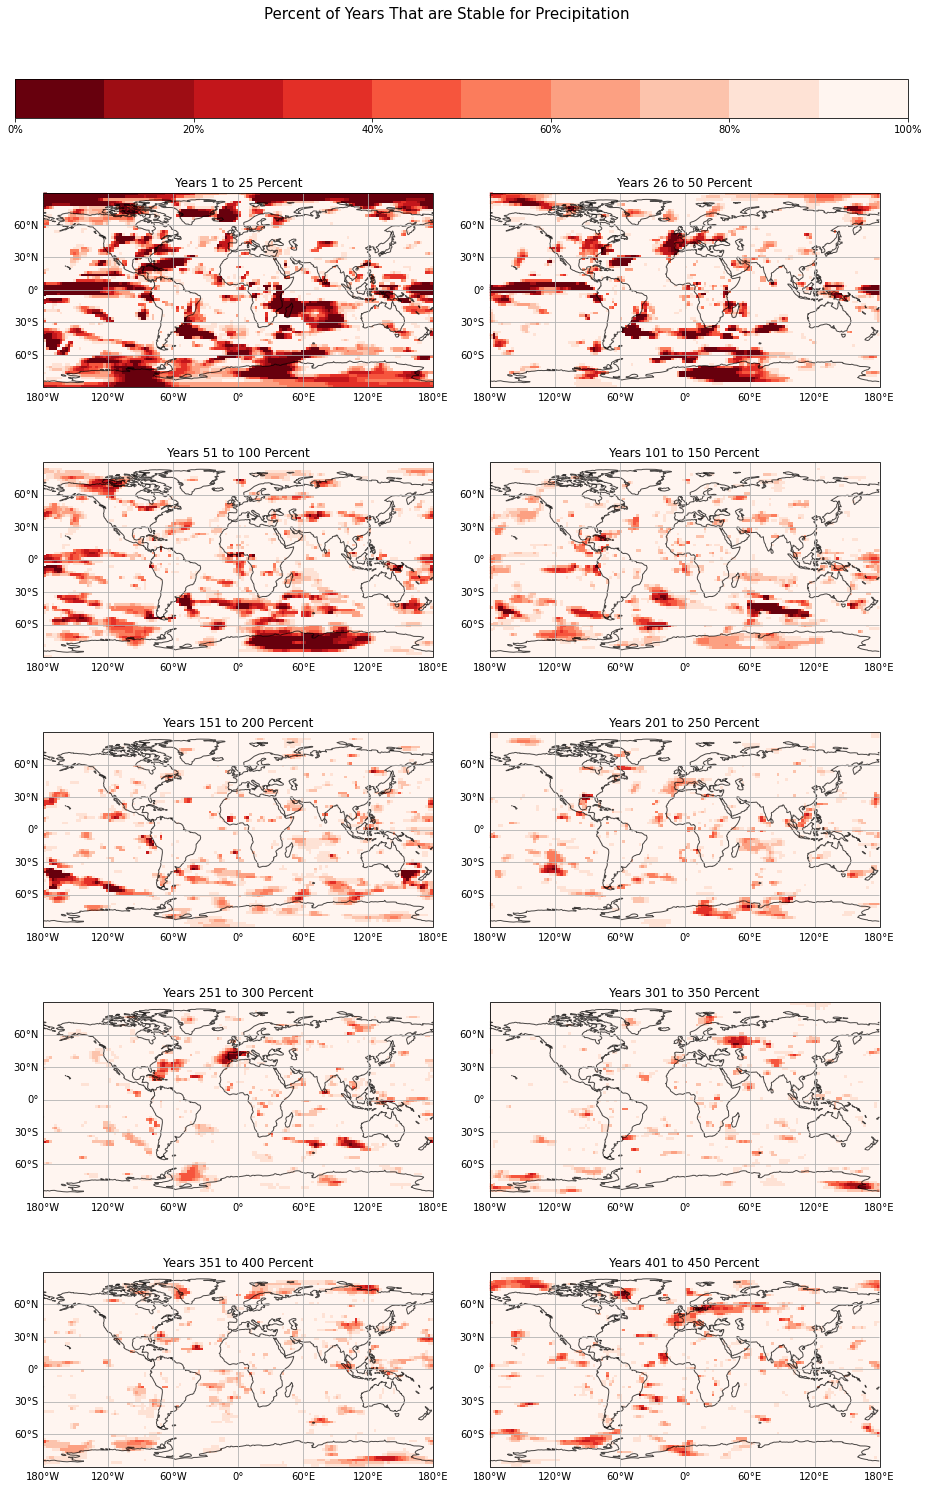

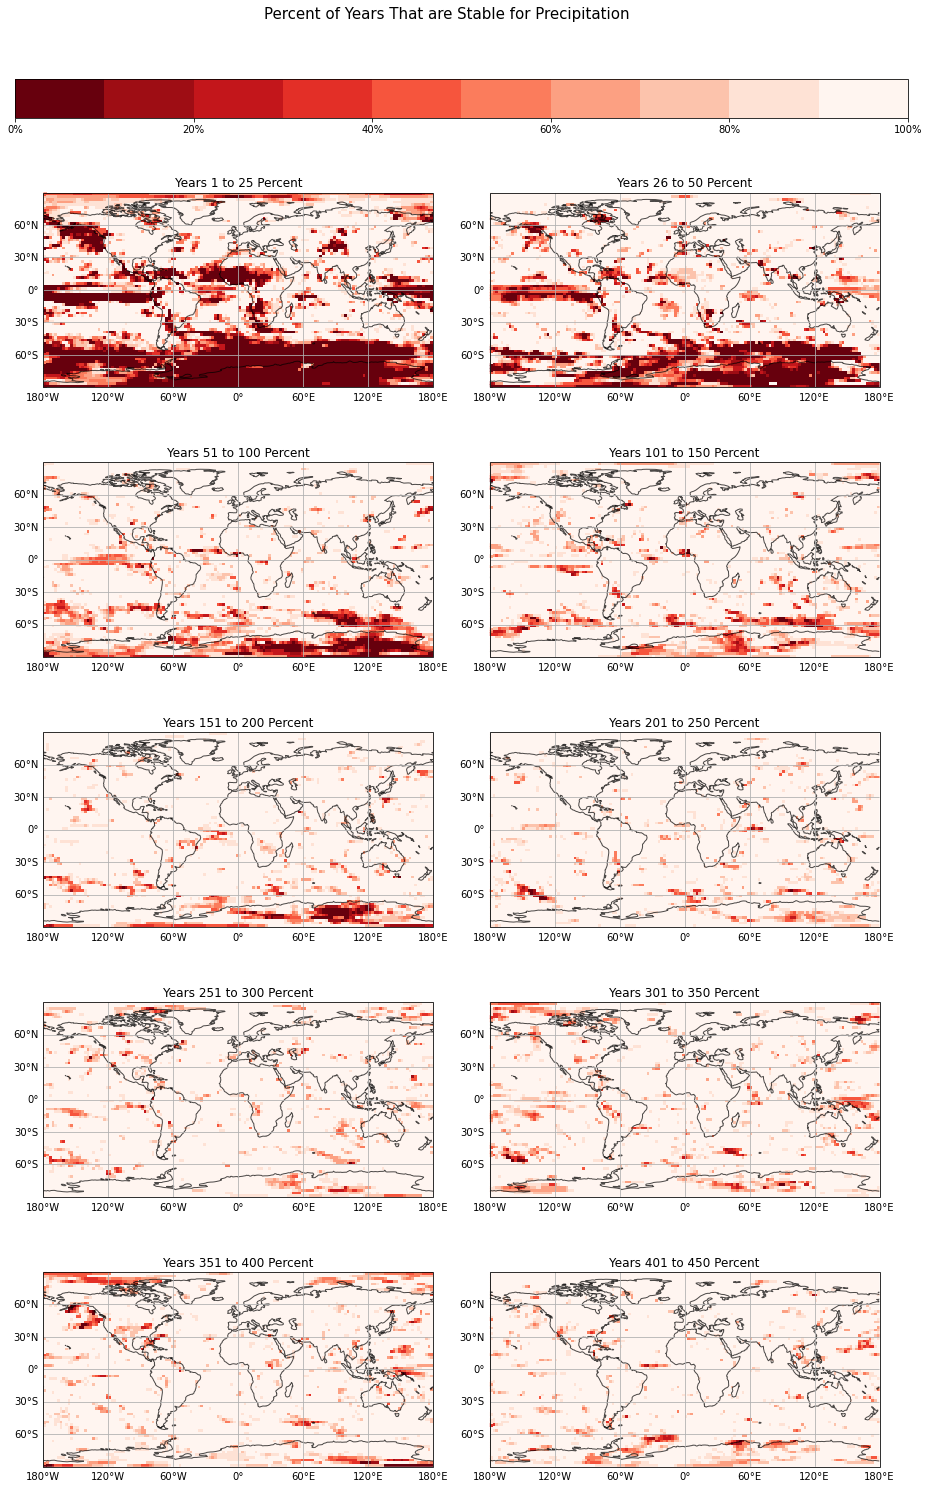

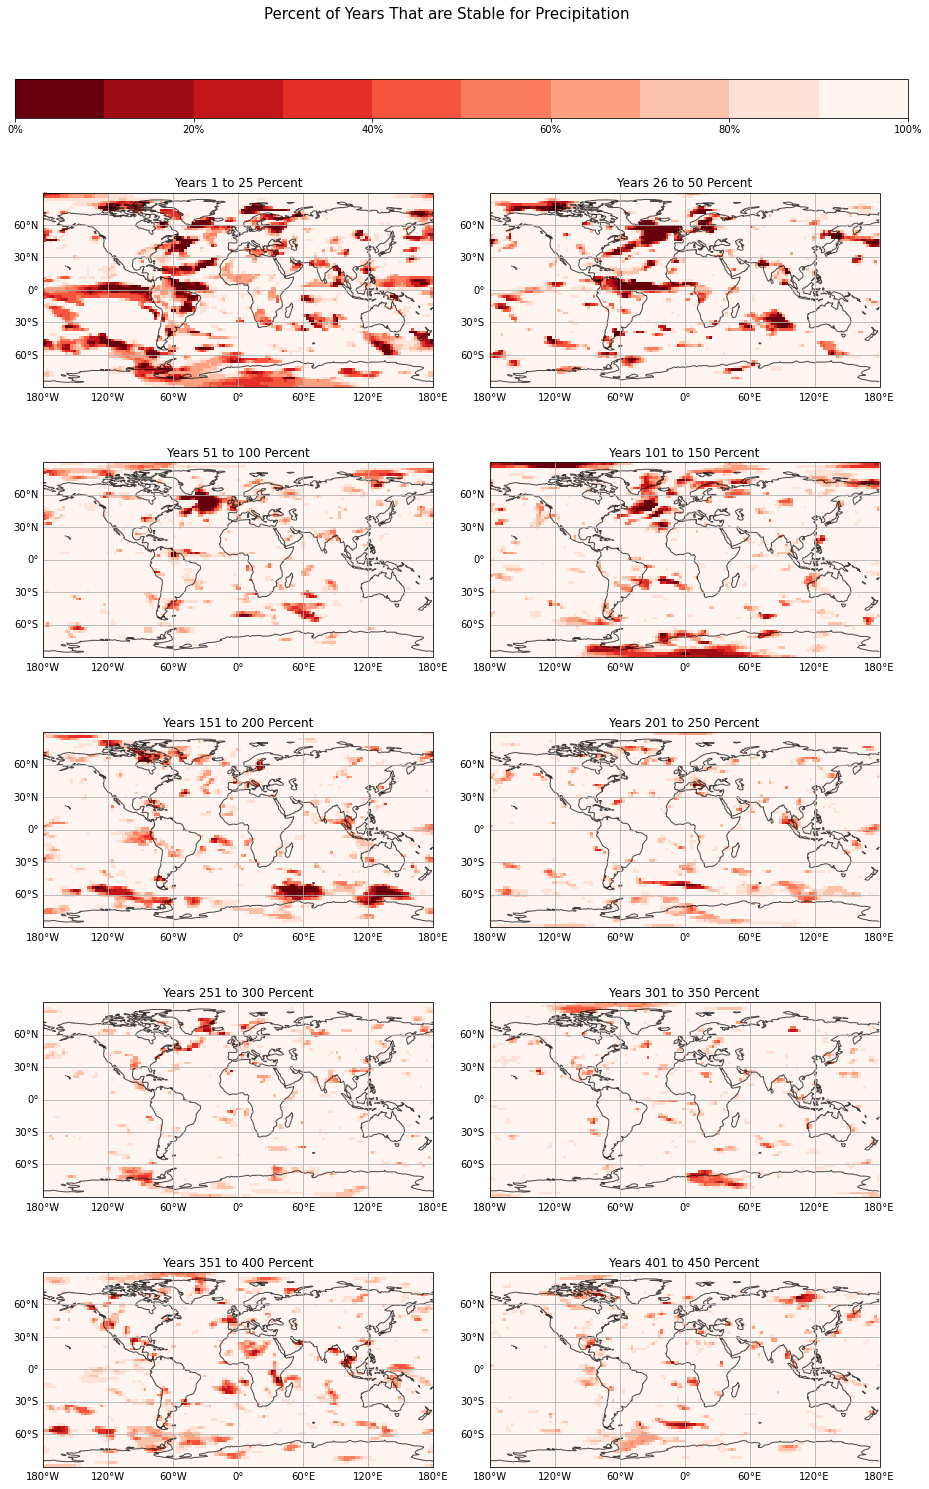

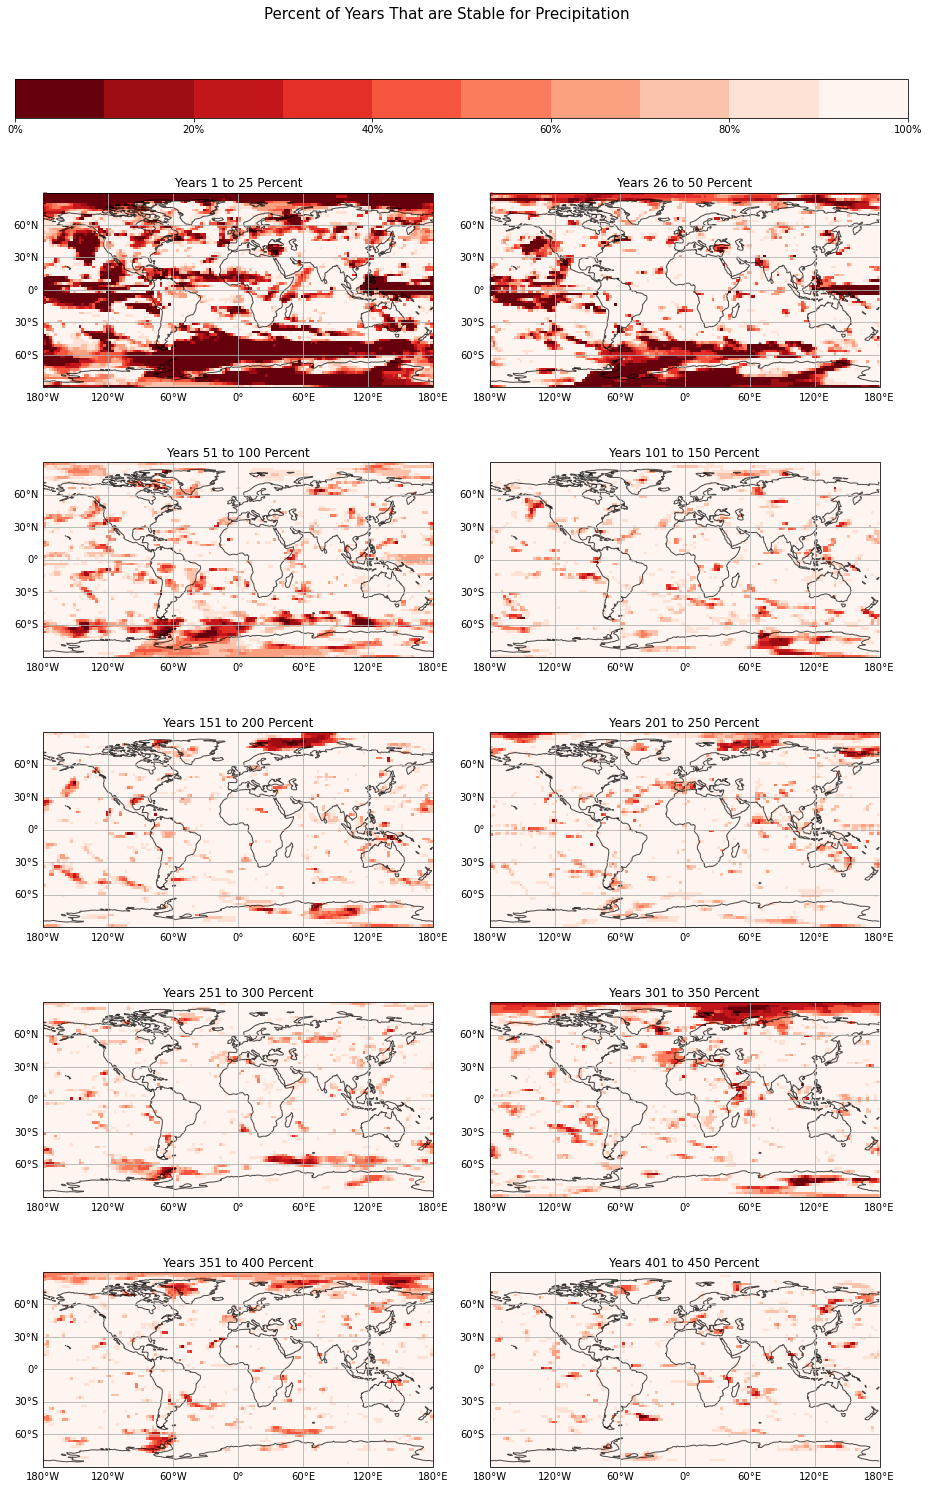

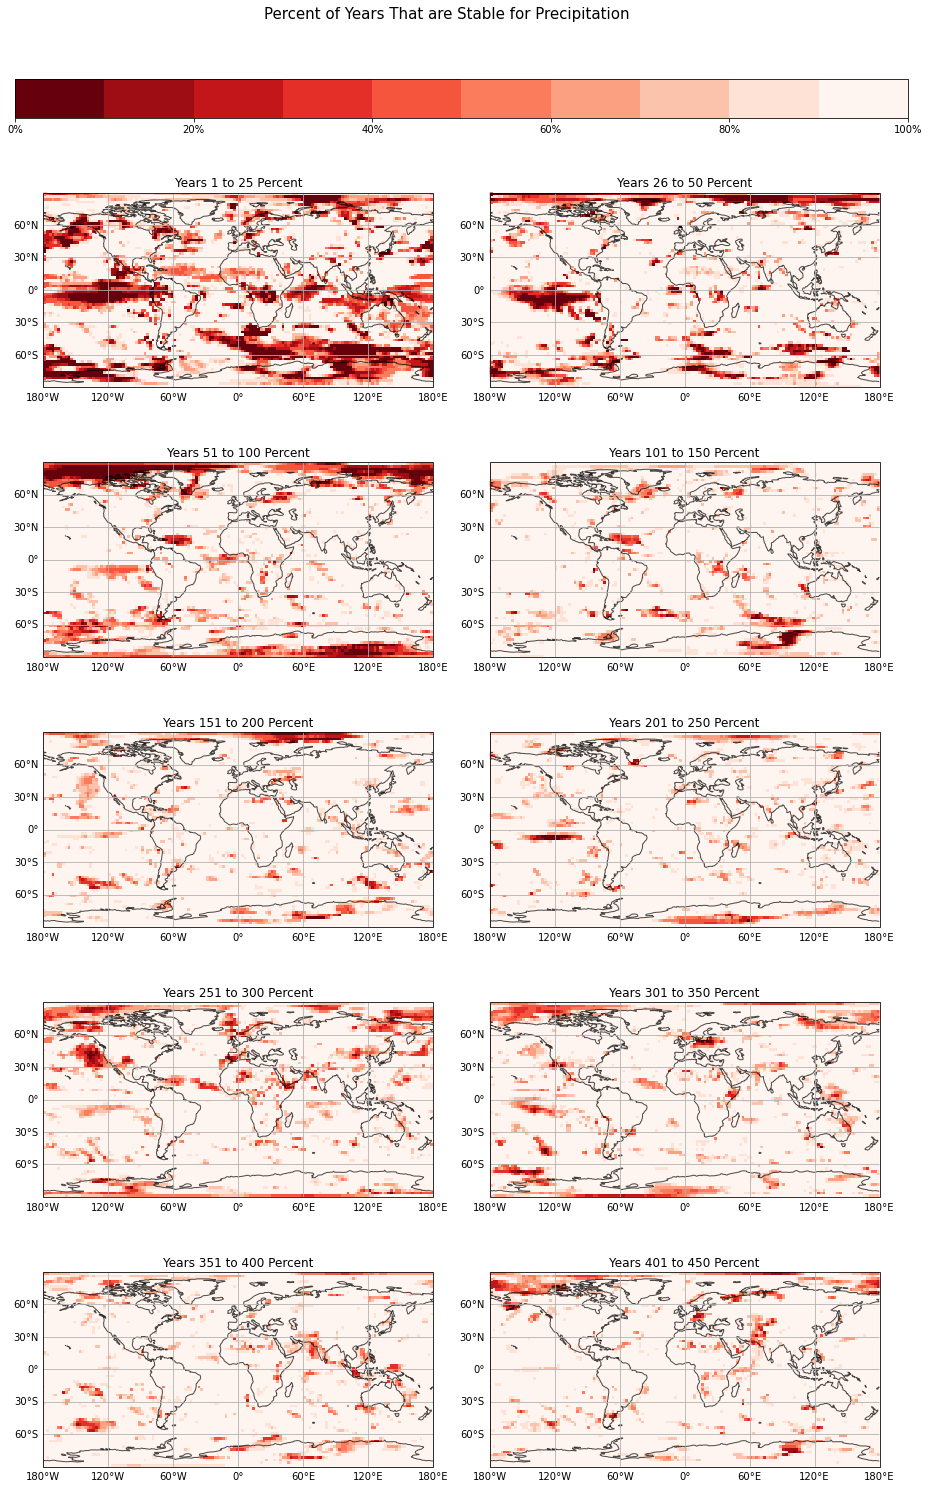

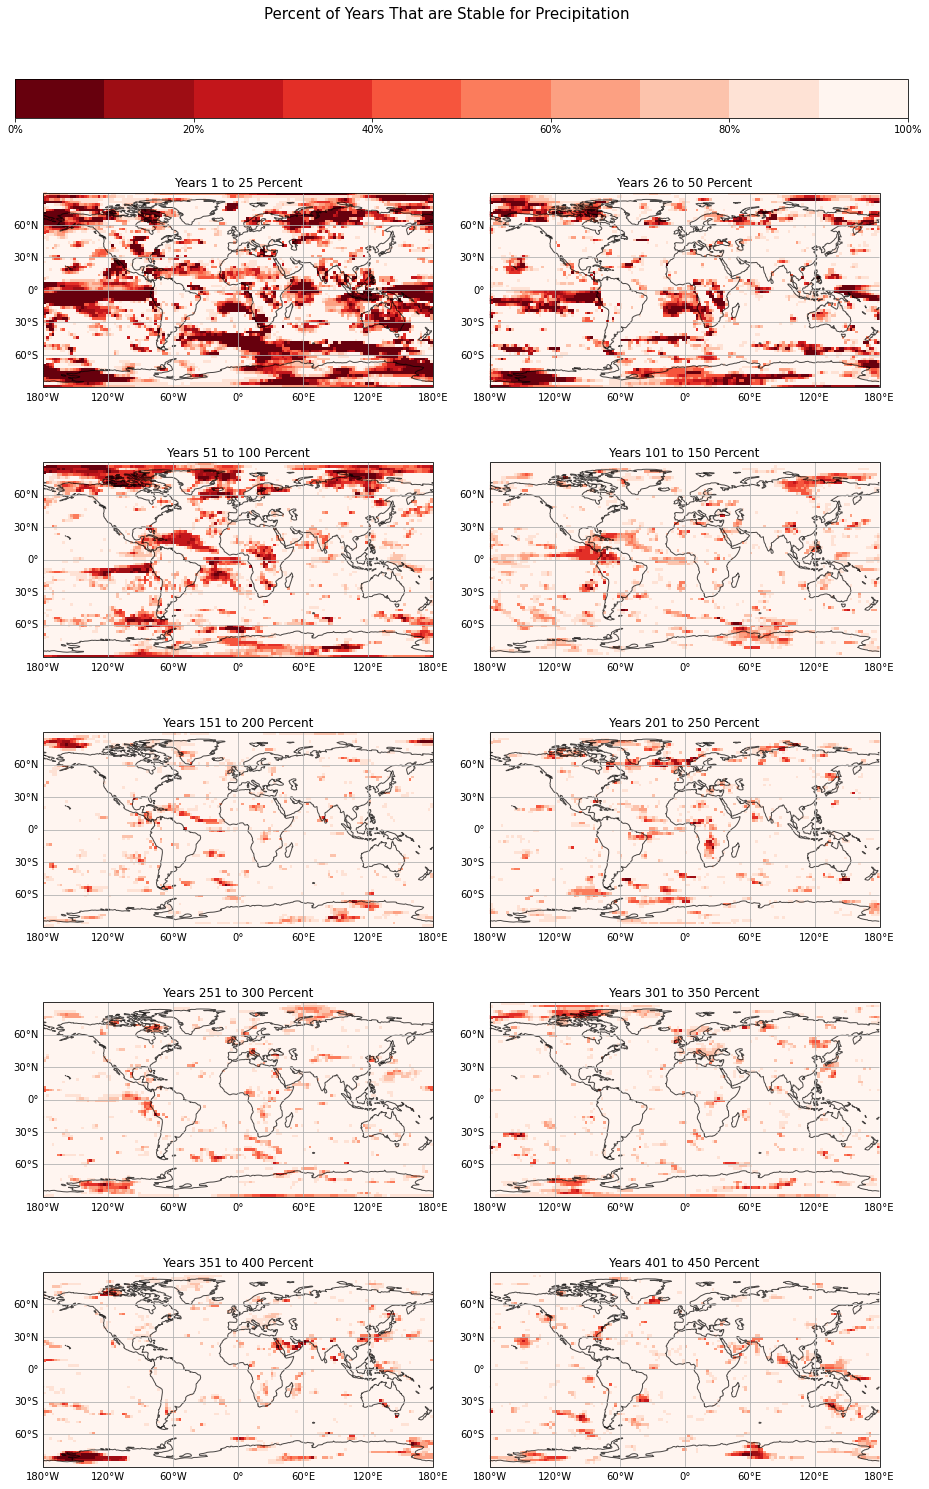

In [94]:
periods = percent_stable_ds.period.values
models = percent_stable_ds.model.values
for model in models:
    fig, gs, cbar = sn_plotting.plot_all_period_maps(
                    percent_stable_ds[['percent']].sel(model=model), periods,
                                           suptitle = f'Percent of Years That are Stable for {longname}',
                                            cmap=cmap, 
                                          col_increase = 2)
    fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, 
                f'{notebook_number}_{variable}_percent_years_stable_and_uncertainty_{window}_{model}.png'),
               bbox_inches='tight', dpi=250)

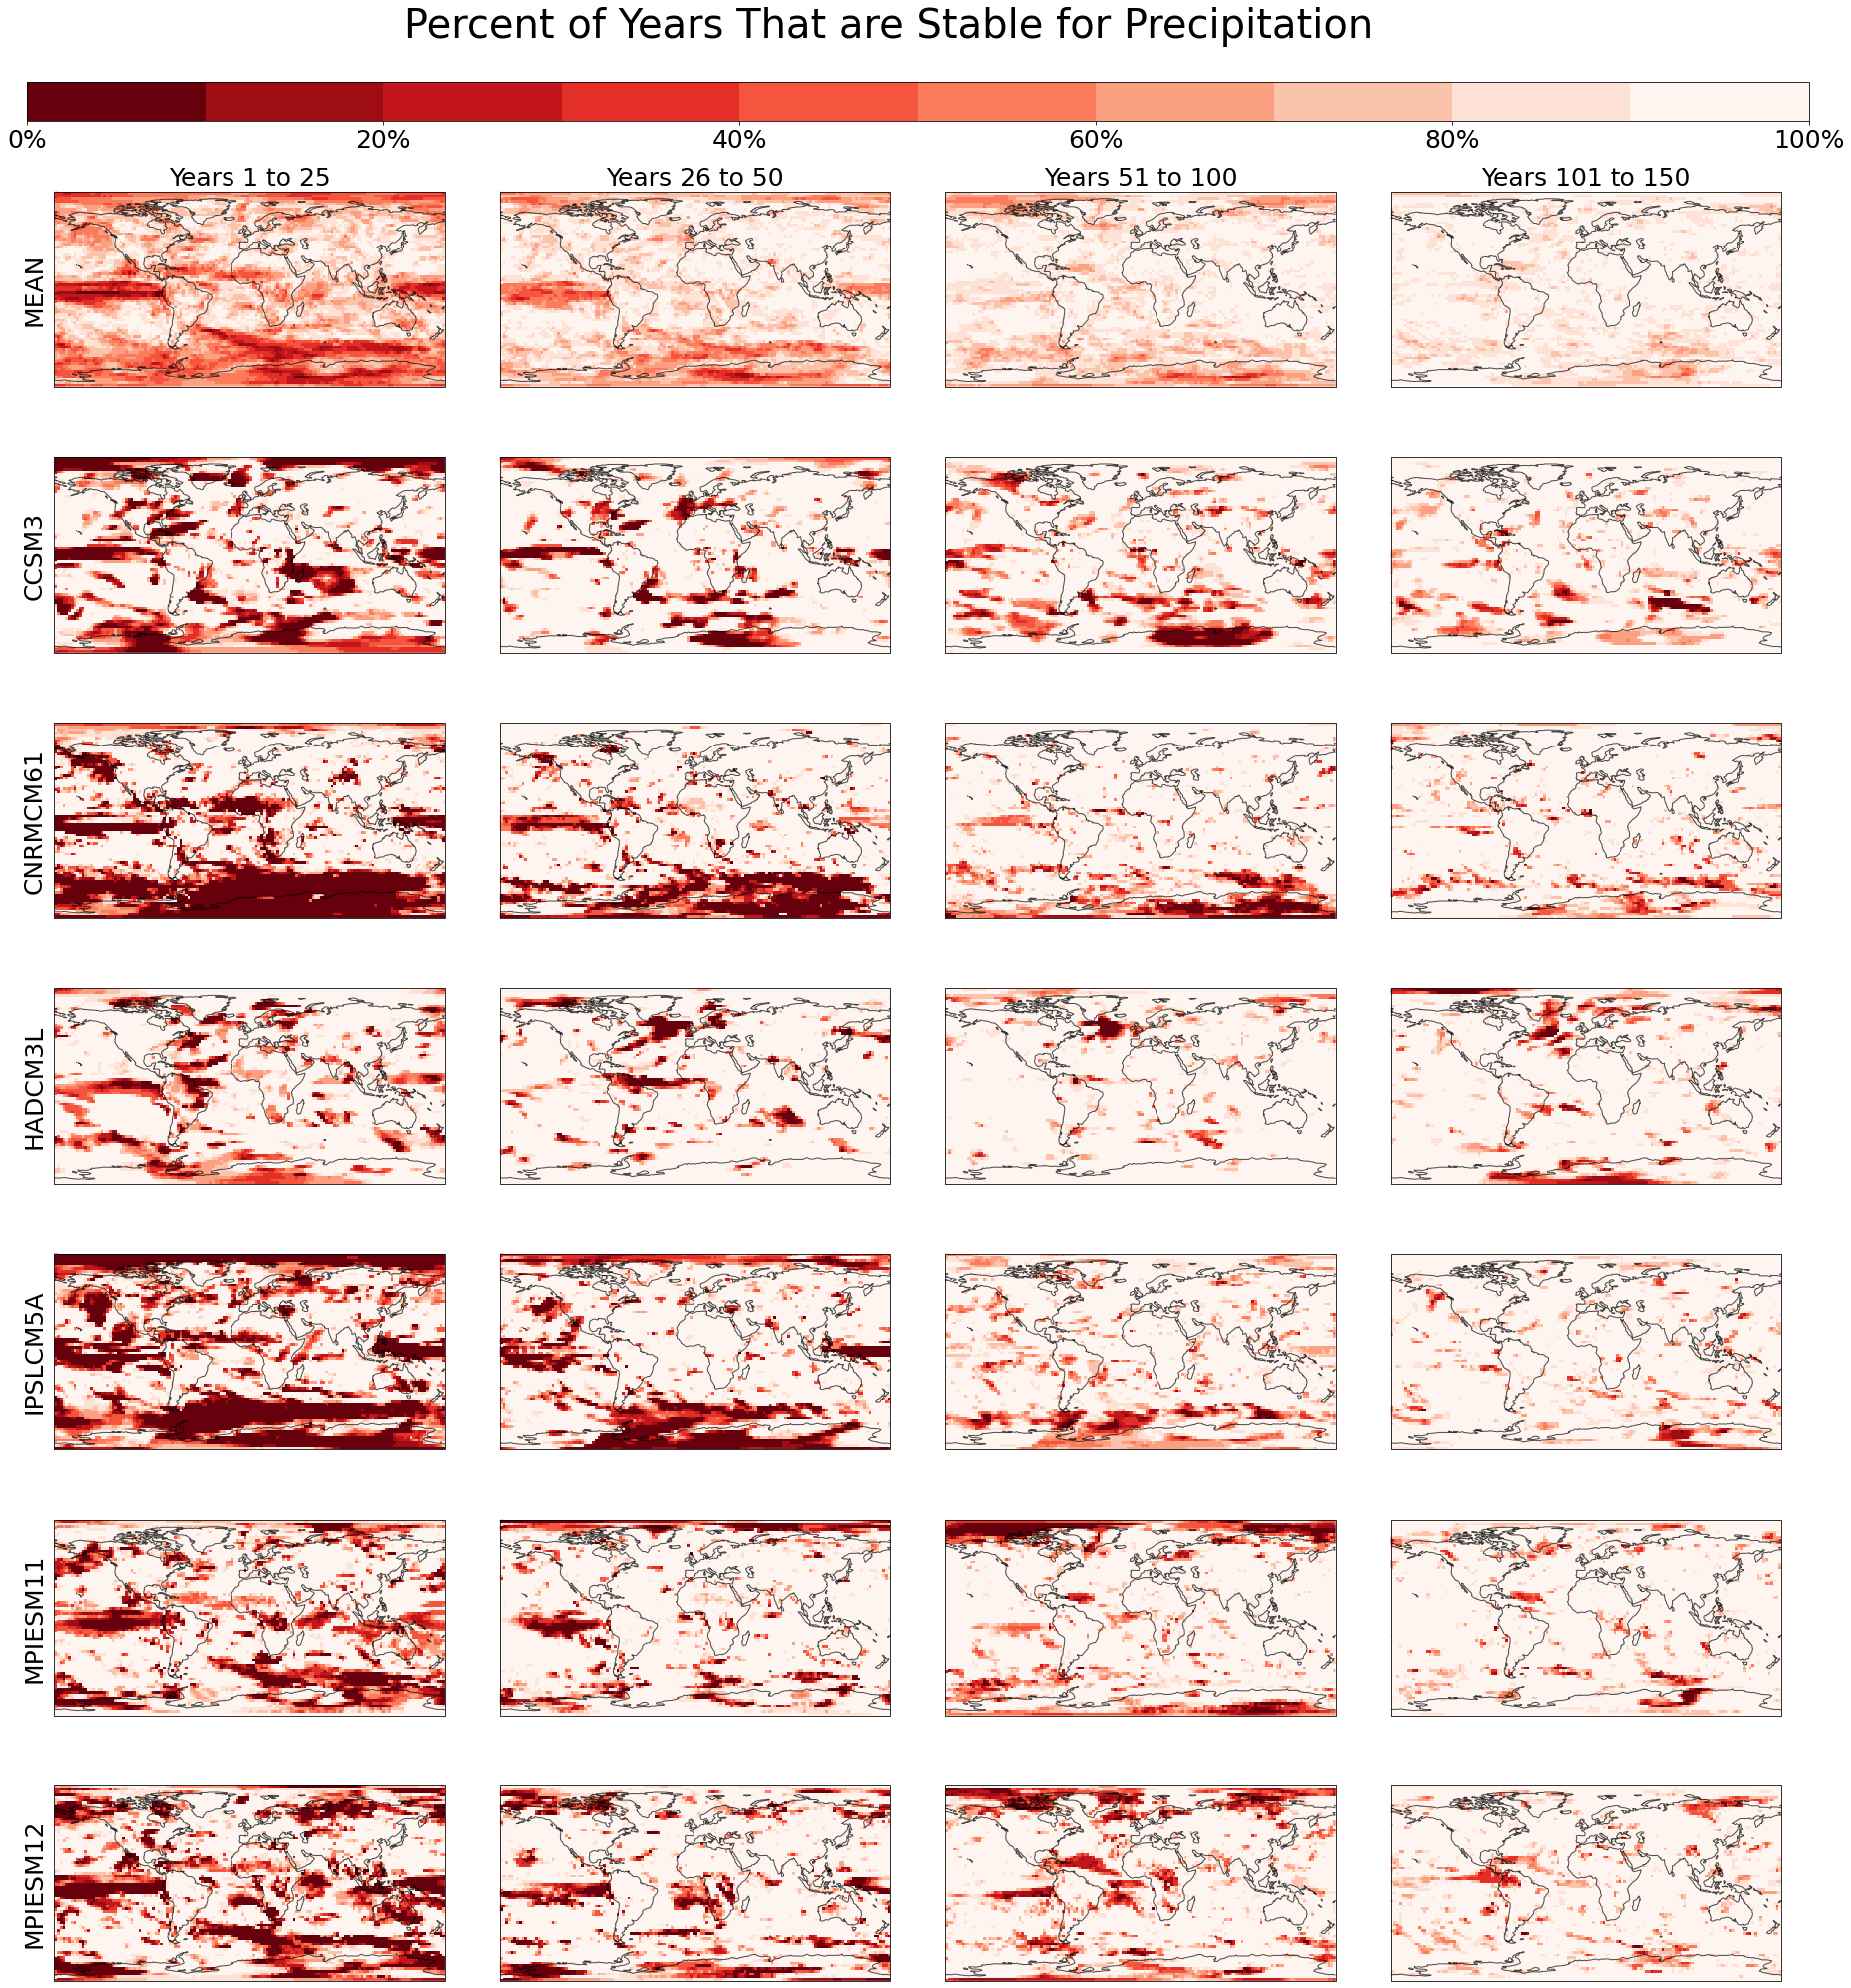

In [95]:
periods = percent_stable_ds.period.values[:4]
models = percent_stable_ds.model.values
models = np.insert(models, 0, 'mean')

ncols = len(periods)
nrows = len(models)
fig = plt.figure(figsize = (8 * ncols, 5 * nrows))
fig.suptitle(f'Percent of Years That are Stable for {longname}', y=0.91, fontsize=40)

gs = gridspec.GridSpec(nrows + 1, ncols, height_ratios = [.2] + [1] * nrows, hspace=0.4, wspace=0)

for row_num, model in enumerate(models, 1):
    for col_num, period in enumerate(periods):
        ax = fig.add_subplot(gs[row_num, col_num], projection=ccrs.PlateCarree())
        
        if model == 'mean':
            da = percent_stable_ds['mean']
        else:
            da = percent_stable_ds['percent'].sel(model=model)

        pcolor = da.sel(period=period).plot(
            ax=ax, vmin=0, vmax=100, cmap=cmap, extend='neither', add_colorbar=False)
        ax.coastlines(alpha=0.7)

        if row_num == 1:
            ax.set_title(utils.convert_period_string(period), fontsize=25);
        else:
            ax.set_title('')
        
        if col_num == 0:
            ax.annotate(model.upper(), size=25, xy = (-.05, 0.5), clip_on=True, xycoords= 'axes fraction',
                       rotation=90, ha='center', va='center')
            
cbar = sn_plotting.format_colorbar(gs, pcolor, labelsize=25)  

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
        f'{notebook_number}_{variable}_percent_years_stable_{window}_all_models.png'),
           bbox_inches='tight')

In [96]:
xticklabels = [utils.convert_period_string(period) for period in pattern_corr_df.columns.values]
xticklabels = [' '.join(x.split(' ')[1:]) for x in xticklabels] # Getting rid of "Years" string start
xticklabels

['1 to 25',
 '26 to 50',
 '51 to 100',
 '101 to 150',
 '151 to 200',
 '201 to 250',
 '251 to 300',
 '301 to 350',
 '351 to 400',
 '401 to 450']

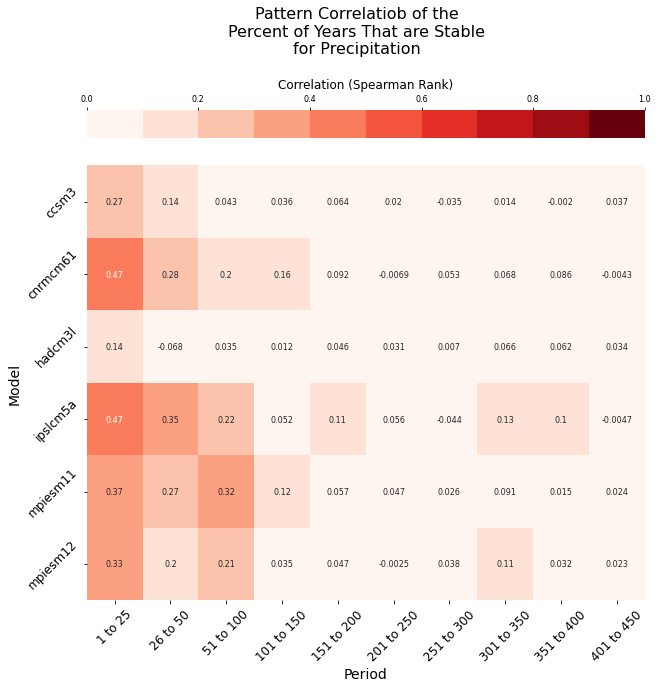

In [97]:
fig = plt.figure(figsize=(10,10))

fig.suptitle(f'Pattern Correlatiob of the\nPercent of Years That are Stable\nfor {longname}', fontsize=16,
            y=0.95)

ax = sns.heatmap(pattern_corr_df, cmap=cmap.reversed(), vmin=0, vmax=1, annot=True, 
           cbar_kws=dict(location='top'), xticklabels = xticklabels,
                annot_kws = dict(fontsize=8))


ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12, rotation=45)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12, rotation=45)


cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_title('Correlation (Spearman Rank)', fontsize=12)

plt.xlabel("Period", size=14)
plt.ylabel("Model", size=14)

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, 
        f'{notebook_number}_{variable}_percent_stable_heat_map.png'), 
           bbox_inches='tight', dpi=200)